# Baltimore City Employee Salary Forecast

**Background:**  
Baltimore is the largest city in the state of Maryland with the largest city payroll. Maryland is a fairly prosperous state with several important industries including services to the federal sector since Washington, DC, is literally next door. Also, Maryland is prominent in the medical and pharmaceutical industries. Again, proximity to federal enities is a driver to this with NIH, NIST and other sources of federal money nearby. Baltimore hosts Social Security Administration and the Centers for Medicare and Medicaid Services which in turn has brought a lot of insurance related jobs to Maryland and Baltimore particularly.  

**Client:**  
Our client is a recruiting company that is intersted in analyzing the employment possibilities in the state and local public sector. Specifically, in this project, we have been contracted to analyze employee employment/salary data in the City of Baltimore to see if salary growth can be predicted.  

**Data:**  
Baltimore pubishes salary data at this URL:  
[Baltimore City Employee Salaries](https://data.baltimorecity.gov/datasets/baltimore::baltimore-city-employee-salaries/explore?showTable=true)  
This dataset includes Baltimore City employee salaries and gross pay from fiscal year 2011 through last fiscal year and includes employees who were employed on June 30 of the last fiscal year.
(Fiscal Year is from July 1 to June 30).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# Shows all columns in dataframe

pd.set_option('display.max_columns', None)


### Input Data  
Data was downloaded from the Baltimore City URL referenced above as a CSV file.  
The CSV file is read into df_origin. df_origin is kept separate as a dataframe with the original pristine data.  
New dataframes are created as needed to facilitate different analyses.


In [3]:
df_origin = pd.read_csv('data/Baltimore_City_Employee_Salaries.csv')

In [4]:
df_origin.head()

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId
0,Aaron,D,Kareem,UTILITIES INST REPAIR II,Public Works - Water & Waste Water,A50,34115.0,44557.99,2018-08-27,FY2021,1
1,Aaron,R,Lynda,ELECTION JUDGES REGULAR,D01,D01,0.0,185.00,2020-12-08,FY2021,2
2,Aaron,G,Patricia,FACILITIES/OFFICE SERVICES II,Mayor's Office of Employment Development,A03,63457.0,29461.96,1979-10-24,FY2021,3
3,Abadir,O,Adam,OPERATIONS OFFICER II,Health Department,A65,74299.0,85450.35,2016-12-12,FY2021,4
4,Abaku,O,Aigbolosimuan,POLICE OFFICER EID,Police Department,A99,68226.0,102775.97,2018-04-17,FY2021,5


In [5]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154187 entries, 0 to 154186
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lastName       153777 non-null  object 
 1   middleInitial  121195 non-null  object 
 2   firstName      154187 non-null  object 
 3   jobClass       154003 non-null  object 
 4   agencyName     154187 non-null  object 
 5   agencyID       154187 non-null  object 
 6   annualSalary   154187 non-null  float64
 7   grossPay       154187 non-null  float64
 8   hireDate       154185 non-null  object 
 9   fiscalYear     154187 non-null  object 
 10  ObjectId       154187 non-null  int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 12.9+ MB


In [6]:
df_origin.columns

Index(['lastName', 'middleInitial', 'firstName', 'jobClass', 'agencyName',
       'agencyID', 'annualSalary', 'grossPay', 'hireDate', 'fiscalYear',
       'ObjectId'],
      dtype='object')

In [7]:
df_origin['agencyName'].value_counts()

Police Department                     34707
Fire Department                       18374
Public Works - Water & Waste Water    16353
Health Department                      9640
Transportation - Highways              7007
                                      ...  
War Memorial Commission                   8
Wage Commissioner                         3
HLTH-Emergency Medical Team               3
FIN-RSP Admin (001)                       2
Una 01 (001)                              1
Name: agencyName, Length: 71, dtype: int64

In [8]:
(df_origin['lastName'] + ',' + df_origin['firstName'] + ' ' + df_origin['hireDate']).value_counts()

Smith,Richard 2008-08-18             14
Johnson,William 2008-08-18           13
Brown,Robert 1981-06-08              13
Johnson,Wayne 1980-02-11             12
Stone,Steven 1982-08-09              12
                                     ..
Quarles-Johnson,Shawna 2018-07-18     1
Queen,Damita 2020-03-08               1
Queen,Tina 2016-06-13                 1
Quick,Ernestine 2006-11-07            1
Zucker,Heather 2007-10-18             1
Length: 31684, dtype: int64

### Selection of relevant departments for this project
**The largest departments by number of employees are listed above. 3 of the top 4 departments (Police, Fire and Health) are concerned with public safety.  
These 3 departments are the focus of this project.  
A new dataframe df_init is being used to carry this reduced data set.**

In [9]:
reqd_depts = ['Police Department', 'Fire Department', 'Health Department']
df_init = df_origin.loc[df_origin['agencyName'].isin(reqd_depts) ]
df_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62721 entries, 3 to 154186
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lastName       62327 non-null  object 
 1   middleInitial  53430 non-null  object 
 2   firstName      62721 non-null  object 
 3   jobClass       62623 non-null  object 
 4   agencyName     62721 non-null  object 
 5   agencyID       62721 non-null  object 
 6   annualSalary   62721 non-null  float64
 7   grossPay       62721 non-null  float64
 8   hireDate       62720 non-null  object 
 9   fiscalYear     62721 non-null  object 
 10  ObjectId       62721 non-null  int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 5.7+ MB


In [10]:
df_init.head()    # Quick visual confirmation that only the required 3 departments rows were included in this dataframe

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId
3,Abadir,O,Adam,OPERATIONS OFFICER II,Health Department,A65,74299.0,85450.35,2016-12-12,FY2021,4
4,Abaku,O,Aigbolosimuan,POLICE OFFICER EID,Police Department,A99,68226.0,102775.97,2018-04-17,FY2021,5
7,Abdal-Rahim,A,Naim,FIRE PUMP OPERATOR SUPPRESSION,Fire Department,A64,72007.0,103168.86,2011-03-30,FY2021,8
8,Abdi,W,Ezekiel,POLICE SERGEANT,Police Department,A99,97058.0,143215.40,2007-06-14,FY2021,9
9,Abdrabou,NaN,Fouad,POLICE OFFICER,Police Department,A99,55117.0,41074.56,2020-08-25,FY2021,10


In [11]:
# df_init.loc[df_init.index, ['fiscalYear']] = df_init['fiscalYear'].str.slice(2,6).astype(int)
# df_init['fiscalYear_new'] = df_init.loc[:, ('fiscalYear')]
# df_init['fiscalYear_new'] = df_init['fiscalYear'].str[2:].copy()
# df_init['fiscalYear_new']
# df_init.loc[df_init.index, ['fiscalYear']] = df_init['fiscalYear'].str.slice(2,6)
# df_init['fiscalYear'] = df_init['fiscalYear'].str.split("Y").str.get(1)
# df_init['fiscalYear']
# df_init['fiscalYear'] = df_init.loc[df_init.fiscalYear, 2:]

In [12]:
df_init['fiscalYear'] = df_init['fiscalYear'].str[-4:]


C:\Users\NM\AppData\Local\Temp\ipykernel_21352\273823209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['fiscalYear'] = df_init['fiscalYear'].str[-4:]


In [13]:
df_init['fiscalYear'] = pd.to_numeric(df_init['fiscalYear'])  # Change fiscal year to integer
df_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62721 entries, 3 to 154186
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lastName       62327 non-null  object 
 1   middleInitial  53430 non-null  object 
 2   firstName      62721 non-null  object 
 3   jobClass       62623 non-null  object 
 4   agencyName     62721 non-null  object 
 5   agencyID       62721 non-null  object 
 6   annualSalary   62721 non-null  float64
 7   grossPay       62721 non-null  float64
 8   hireDate       62720 non-null  object 
 9   fiscalYear     62721 non-null  int64  
 10  ObjectId       62721 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.7+ MB


C:\Users\NM\AppData\Local\Temp\ipykernel_21352\967762316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['fiscalYear'] = pd.to_numeric(df_init['fiscalYear'])  # Change fiscal year to integer


In [14]:
df_init['date'] = df_init['fiscalYear'] * 10000 + 101
df_init['date'] = df_init['date'].astype(str)

C:\Users\NM\AppData\Local\Temp\ipykernel_21352\4246559777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['date'] = df_init['fiscalYear'] * 10000 + 101
C:\Users\NM\AppData\Local\Temp\ipykernel_21352\4246559777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['date'] = df_init['date'].astype(str)


In [15]:
df_init = df_init.set_index(pd.to_datetime((df_init['date']), yearfirst=True))
df_init.head()     # Confirm that Index has been set to date

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId,date
date,,,,,,,,,,,,
2021-01-01,Abadir,O,Adam,OPERATIONS OFFICER II,Health Department,A65,74299.0,85450.35,2016-12-12,2021,4,20210101
2021-01-01,Abaku,O,Aigbolosimuan,POLICE OFFICER EID,Police Department,A99,68226.0,102775.97,2018-04-17,2021,5,20210101
2021-01-01,Abdal-Rahim,A,Naim,FIRE PUMP OPERATOR SUPPRESSION,Fire Department,A64,72007.0,103168.86,2011-03-30,2021,8,20210101
2021-01-01,Abdi,W,Ezekiel,POLICE SERGEANT,Police Department,A99,97058.0,143215.40,2007-06-14,2021,9,20210101
2021-01-01,Abdrabou,NaN,Fouad,POLICE OFFICER,Police Department,A99,55117.0,41074.56,2020-08-25,2021,10,20210101


In [16]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62721 entries, 2021-01-01 to 2011-01-01
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lastName       62327 non-null  object 
 1   middleInitial  53430 non-null  object 
 2   firstName      62721 non-null  object 
 3   jobClass       62623 non-null  object 
 4   agencyName     62721 non-null  object 
 5   agencyID       62721 non-null  object 
 6   annualSalary   62721 non-null  float64
 7   grossPay       62721 non-null  float64
 8   hireDate       62720 non-null  object 
 9   fiscalYear     62721 non-null  int64  
 10  ObjectId       62721 non-null  int64  
 11  date           62721 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 6.2+ MB


**There are 62,721 entries.**  
- middleInitial column has nulls but that is expected.  
- hireDate has a null. Need to investigate.  
- lastName has almost 400 nulls. Need to investigate.**

In [17]:
# Sorting - No longer needed
# df_init.sort_values(by = ['agencyName','lastName', 'firstName', 'hireDate', 'fiscalYear'], ascending = [True, True, True, True, False], inplace = True)

**Investigate the nulls in the lastName column.**

In [18]:
df_init.loc[df_init['lastName'].isna()]

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId,date
date,,,,,,,,,,,,
2019-01-01,NaN,1,BPD,BPD 1,Police Department,A99,90833.0,115187.12,1999-02-11,2019,43679,20190101
2019-01-01,NaN,0,BPD,BPD 10,Police Department,A99,87151.0,120470.46,2001-01-03,2019,43680,20190101
2019-01-01,NaN,1,BPD,BPD 11,Police Department,A99,91008.0,112361.89,1996-08-01,2019,43689,20190101
2019-01-01,NaN,2,BPD,BPD 12,Police Department,A99,80295.0,97460.98,2007-02-20,2019,43695,20190101
2019-01-01,NaN,2,BPD,BPD 2,Police Department,A99,90833.0,109199.22,1999-01-25,2019,43701,20190101
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-01,NaN,9,BPD,BPD,Police Department,A99,65499.0,64127.83,1970-01-01,2011,154183,20110101
2011-01-01,NaN,0,BPD,BPD,Police Department,A99,63384.0,66187.45,1970-01-01,2011,154184,20110101
2011-01-01,NaN,1,BPD,BPD,Police Department,A99,61102.0,71989.51,1970-01-01,2011,154185,20110101


**All the nulls are in lastName are for employees in the Police Department. The firstName entry is "BPD" for all of them. They have different hire dates and so imply that they are real persons but their identity is not being revealed.  
To make the data easier to work with, we have entered the value "BPD" into all the null lastName entries.**

In [19]:
# df_init['lastName'].fillna('BPD', inplace = True)
df_init.loc[df_init['lastName'].isna(), 'lastName'] = 'BPD'

In [20]:
df_init.loc[df_init['lastName'] == 'BPD']

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId,date
date,,,,,,,,,,,,
2019-01-01,BPD,1,BPD,BPD 1,Police Department,A99,90833.0,115187.12,1999-02-11,2019,43679,20190101
2019-01-01,BPD,0,BPD,BPD 10,Police Department,A99,87151.0,120470.46,2001-01-03,2019,43680,20190101
2019-01-01,BPD,1,BPD,BPD 11,Police Department,A99,91008.0,112361.89,1996-08-01,2019,43689,20190101
2019-01-01,BPD,2,BPD,BPD 12,Police Department,A99,80295.0,97460.98,2007-02-20,2019,43695,20190101
2019-01-01,BPD,2,BPD,BPD 2,Police Department,A99,90833.0,109199.22,1999-01-25,2019,43701,20190101
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-01,BPD,9,BPD,BPD,Police Department,A99,65499.0,64127.83,1970-01-01,2011,154183,20110101
2011-01-01,BPD,0,BPD,BPD,Police Department,A99,63384.0,66187.45,1970-01-01,2011,154184,20110101
2011-01-01,BPD,1,BPD,BPD,Police Department,A99,61102.0,71989.51,1970-01-01,2011,154185,20110101


In [21]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62721 entries, 2021-01-01 to 2011-01-01
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lastName       62721 non-null  object 
 1   middleInitial  53430 non-null  object 
 2   firstName      62721 non-null  object 
 3   jobClass       62623 non-null  object 
 4   agencyName     62721 non-null  object 
 5   agencyID       62721 non-null  object 
 6   annualSalary   62721 non-null  float64
 7   grossPay       62721 non-null  float64
 8   hireDate       62720 non-null  object 
 9   fiscalYear     62721 non-null  int64  
 10  ObjectId       62721 non-null  int64  
 11  date           62721 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 6.2+ MB


**Looking at the single row with null hireDate.**

In [22]:
df_init.loc[df_init['hireDate'].isna()]

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId,date
date,,,,,,,,,,,,
2021-01-01,Horsey,C,Rashad,POLICE OFFICER TRAINEE,Police Department,A99,55117.0,20857.58,NaN,2021,6098,20210101


**The lack of a hireDate value appears to be a mistake or ovesight. The rest of the data is relevant and the hireDate is not being used in this current analysis. So, this row was allowed to remain.**

In [23]:
# In initial analysis, we only looked at the previous 8 years but ultimately decided to look at all 11 years.
# df_recent_yrs = df_init.loc[df_init['fiscalYear'] >= 2014]

### Create Unique "Employee ID"
**In viewing the data, it is clear that the combination of first name, last name and hire date idenitifies a unique employee. Generating a unique employee ID allows us to analyze how many employees they are and investigate the history of each individual or potentially job categories/titles - some of this will be carried out later.**

In [24]:
df_init['empId'] = df_init['lastName'] + ',' + df_init['firstName'] + ' ' + df_init['hireDate']

In [25]:
df_init.head()

,lastName,middleInitial,firstName,jobClass,agencyName,agencyID,annualSalary,grossPay,hireDate,fiscalYear,ObjectId,date,empId
date,,,,,,,,,,,,,
2021-01-01,Abadir,O,Adam,OPERATIONS OFFICER II,Health Department,A65,74299.0,85450.35,2016-12-12,2021,4,20210101,"Abadir,Adam 2016-12-12"
2021-01-01,Abaku,O,Aigbolosimuan,POLICE OFFICER EID,Police Department,A99,68226.0,102775.97,2018-04-17,2021,5,20210101,"Abaku,Aigbolosimuan 2018-04-17"
2021-01-01,Abdal-Rahim,A,Naim,FIRE PUMP OPERATOR SUPPRESSION,Fire Department,A64,72007.0,103168.86,2011-03-30,2021,8,20210101,"Abdal-Rahim,Naim 2011-03-30"
2021-01-01,Abdi,W,Ezekiel,POLICE SERGEANT,Police Department,A99,97058.0,143215.40,2007-06-14,2021,9,20210101,"Abdi,Ezekiel 2007-06-14"
2021-01-01,Abdrabou,NaN,Fouad,POLICE OFFICER,Police Department,A99,55117.0,41074.56,2020-08-25,2021,10,20210101,"Abdrabou,Fouad 2020-08-25"


In [26]:
df_init['agencyName'].value_counts()

Police Department    34707
Fire Department      18374
Health Department     9640
Name: agencyName, dtype: int64

In [27]:
df_init['agencyName'].value_counts().sum()

62721

**The above 2 cells show us that there are 62,721 records and how many are in each department. However, there is a record for each employee for each year worked.**

In [28]:
print('# Baltimore City Employee in Data Set:', len(df_init['empId'].unique()))

# Baltimore City Employee in Data Set: 11392


**So, the number of unique employees over the 11 year period of the data set is 11,392.**

### Remove unnecessary columns

In [29]:
df_init = df_init.drop(['lastName', 'middleInitial', 'firstName', 'agencyID', 'grossPay', 'hireDate','ObjectId', 'date'], axis=1)

In [30]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62721 entries, 2021-01-01 to 2011-01-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   jobClass      62623 non-null  object 
 1   agencyName    62721 non-null  object 
 2   annualSalary  62721 non-null  float64
 3   fiscalYear    62721 non-null  int64  
 4   empId         62720 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.9+ MB


In [31]:
df_init.head()

,jobClass,agencyName,annualSalary,fiscalYear,empId
date,,,,,
2021-01-01,OPERATIONS OFFICER II,Health Department,74299.0,2021,"Abadir,Adam 2016-12-12"
2021-01-01,POLICE OFFICER EID,Police Department,68226.0,2021,"Abaku,Aigbolosimuan 2018-04-17"
2021-01-01,FIRE PUMP OPERATOR SUPPRESSION,Fire Department,72007.0,2021,"Abdal-Rahim,Naim 2011-03-30"
2021-01-01,POLICE SERGEANT,Police Department,97058.0,2021,"Abdi,Ezekiel 2007-06-14"
2021-01-01,POLICE OFFICER,Police Department,55117.0,2021,"Abdrabou,Fouad 2020-08-25"


### Create separate dataframes for Police, Fire and Health Departments

In [32]:
df_police = df_init.loc[df_init['agencyName'] == 'Police Department']
df_fire = df_init.loc[df_init['agencyName'] == 'Fire Department']
df_health = df_init.loc[df_init['agencyName'] == 'Health Department']

print('# Police Employees in Data Set:', len(df_police['empId'].unique()))
print('# Fire Employees in Data Set:', len(df_fire['empId'].unique()))
print('# Health Employees in Data Set:', len(df_health['empId'].unique()))

# Police Employees in Data Set: 6127
# Fire Employees in Data Set: 2791
# Health Employees in Data Set: 2554


### Calculate Payroll Sums in Each Department

In [33]:
label_format = '{:,.0f}'          # This label format will be used in subsequent plots.

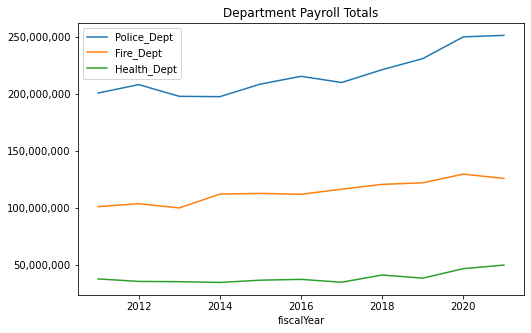

In [34]:
# Line Chart
payroll_police=[]
payroll_fire=[]
payroll_health=[]
payroll_years=[]

for year in range(2011,2022):
    payroll_police.append(df_police.loc[df_police['fiscalYear'] == year]['annualSalary'].sum())
    payroll_fire.append(df_fire.loc[df_fire['fiscalYear'] == year]['annualSalary'].sum())
    payroll_health.append(df_health.loc[df_health['fiscalYear'] == year]['annualSalary'].sum())
    payroll_years.append(year)

df_pay_sum = pd.DataFrame(list(zip(payroll_years, payroll_police, payroll_fire, payroll_health)))
df_pay_sum.columns = ['fiscalYear', 'Police_Dept', 'Fire_Dept', 'Health_Dept']
df_pay_sum.head(20)

df_pay_sum.plot(x="fiscalYear", y=["Police_Dept", "Fire_Dept", "Health_Dept"], kind="line", figsize=(8, 5))
ax=plt.gca()
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([label_format.format(x) for x in ticks_loc])
ax.set_title('Department Payroll Totals')
plt.savefig('./images/Department_Payroll_Totals(Line).png',bbox_inches='tight');

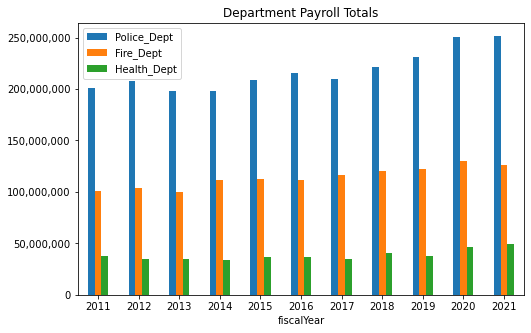

In [35]:
# Bar Chart
df_pay_sum.plot(x="fiscalYear", y=["Police_Dept", "Fire_Dept", "Health_Dept"], kind="bar", rot=0, figsize=(8, 5))
ax=plt.gca()
ticks_loc = ax.get_yticks().tolist()

ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([label_format.format(x) for x in ticks_loc])
ax.set_title('Department Payroll Totals')
plt.savefig('./images/Department_Payroll_Totals(Bar).png',bbox_inches='tight');

In [36]:
df_pay_sum

,fiscalYear,Police_Dept,Fire_Dept,Health_Dept
0,2011,2.008713e+08,1.009713e+08,37423219.00
1,2012,2.082891e+08,1.035812e+08,35206610.00
2,2013,1.979702e+08,9.983872e+07,34961857.00
3,2014,1.976886e+08,1.120108e+08,34305637.00
4,2015,2.087338e+08,1.126165e+08,36294814.00
5,2016,2.155936e+08,1.118375e+08,37012032.00
6,2017,2.101303e+08,1.163164e+08,34486200.00
7,2018,2.213949e+08,1.205536e+08,40824800.00
8,2019,2.311541e+08,1.219408e+08,38077508.50
9,2020,2.502885e+08,1.295694e+08,46438958.00


### Calculate Mean of Salaries in Each Department

In [37]:
pay_mean_police=[]
pay_mean_fire=[]
pay_mean_health=[]
pay_mean_years=[]

for year in range(2011,2022):
    pay_mean_police.append(df_police.loc[df_police['fiscalYear'] == year]['annualSalary'].mean())
    pay_mean_fire.append(df_fire.loc[df_fire['fiscalYear'] == year]['annualSalary'].mean())
    pay_mean_health.append(df_health.loc[df_health['fiscalYear'] == year]['annualSalary'].mean())
    pay_mean_years.append(year)

df_pay_mean = pd.DataFrame(list(zip(pay_mean_years, pay_mean_police, pay_mean_fire, pay_mean_health)))
df_pay_mean.columns = ['fiscalYear', 'Police_Dept', 'Fire_Dept', 'Health_Dept']

df_pay_mean['date'] = df_pay_mean['fiscalYear'] * 10000 + 101
df_pay_mean['date'] = df_pay_mean['date'].astype(str)
df_pay_mean = df_pay_mean.set_index(pd.to_datetime((df_pay_mean['date']), yearfirst=True))


In [38]:
df_pay_mean = df_pay_mean.drop(['date'], axis=1)
df_pay_mean.head(20)     # Confirm that Index has been set to date

,fiscalYear,Police_Dept,Fire_Dept,Health_Dept
date,,,,
2011-01-01,2011,58597.219186,58500.200463,40024.833155
2012-01-01,2012,59939.296748,59873.554913,41468.327444
2013-01-01,2013,60467.387660,60877.271341,39819.882688
2014-01-01,2014,61719.831720,71072.849055,41332.092771
2015-01-01,2015,67507.705692,69818.044637,42649.605170
2016-01-01,2016,71649.581921,69811.160424,41680.216216
2017-01-01,2017,72508.720842,70537.532444,46228.150134
2018-01-01,2018,73921.511519,71460.327208,47141.801386
2019-01-01,2019,78597.113567,72670.302741,48138.443110


In [39]:
df_pay_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2011-01-01 to 2021-01-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fiscalYear   11 non-null     int64  
 1   Police_Dept  11 non-null     float64
 2   Fire_Dept    11 non-null     float64
 3   Health_Dept  11 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 440.0 bytes


In [40]:
# df_pay_mean = df_payroll.set_index(pd.to_datetime((df_pay_mean['date']), yearfirst=True))

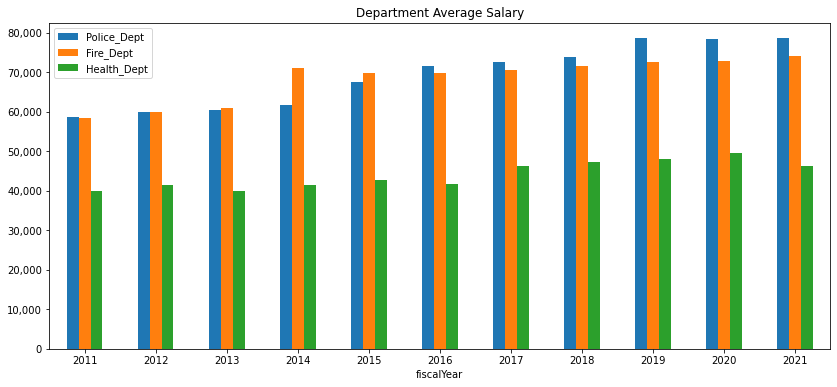

In [41]:
df_pay_mean.plot(x="fiscalYear", y=["Police_Dept", "Fire_Dept", "Health_Dept"], kind="bar", rot=0, figsize=(14, 6))
ax=plt.gca()
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([label_format.format(x) for x in ticks_loc])
ax.set_title('Department Average Salary')
plt.savefig('./images/Department_Average_Salary(Bar).png',bbox_inches='tight');

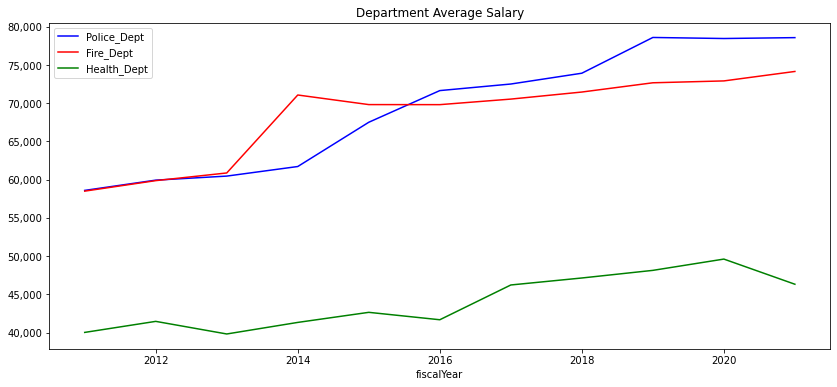

In [42]:
df_pay_mean.plot(x="fiscalYear", y=["Police_Dept", "Fire_Dept","Health_Dept"], kind="line", figsize=(14, 6), color=('blue','red','green'))
ax=plt.gca()
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([label_format.format(x) for x in ticks_loc]);
ax.set_title('Department Average Salary')
plt.savefig('./images/Department_Average_Salary(Line).png',bbox_inches='tight');


## Train Test Split

In [43]:
cutoff = round(df_pay_mean.shape[0]*0.8)
cutoff

9

**Remember that there are only 11 years or 11 points of time. 9 will be allocated to the training set and 2 to the test set.**  
**So 2011-2019 is the train set and 2020-2021 is the test set.**

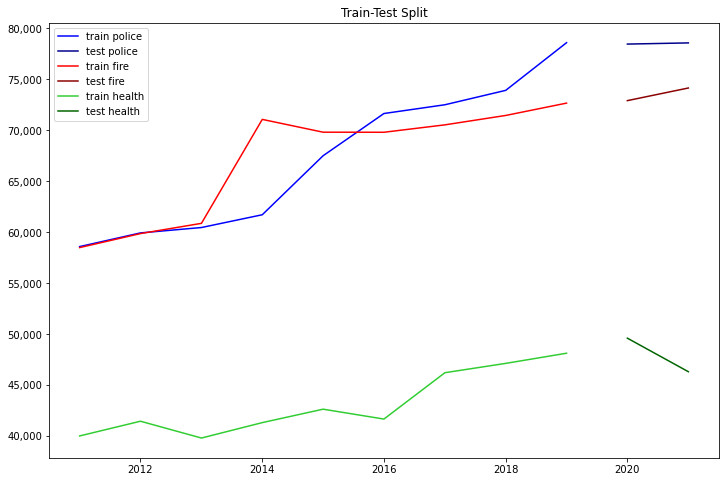

In [44]:
train_police = df_pay_mean[:cutoff]['Police_Dept']
test_police = df_pay_mean[cutoff:]['Police_Dept']
train_fire = df_pay_mean[:cutoff]['Fire_Dept']
test_fire = df_pay_mean[cutoff:]['Fire_Dept']
train_health = df_pay_mean[:cutoff]['Health_Dept']
test_health = df_pay_mean[cutoff:]['Health_Dept']
train_years = df_pay_mean.index[:cutoff]

fig, ax = plt.subplots(figsize=(12, 8))
# train_police.plot(x="fiscalYear", y=["Police_Dept", "Fire_Dept","Health_Dept"], kind="line", figsize=(14, 6), color=('blue','red','green'))

ax.plot(train_police, label='train police', color='blue')
ax.plot(test_police, label='test police', color='darkblue')
ax.plot(train_fire, label='train fire', color='red')
ax.plot(test_fire, label='test fire', color='darkred')
ax.plot(train_health, label='train health', color='limegreen')
ax.plot(test_health, label='test health', color='darkgreen')

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([label_format.format(x) for x in ticks_loc]);

ax.set_title('Train-Test Split')
plt.legend()
plt.savefig('./images/Train-Test_Split.png',bbox_inches='tight');


In [45]:
train_police.head(20)

date
2011-01-01    58597.219186
2012-01-01    59939.296748
2013-01-01    60467.387660
2014-01-01    61719.831720
2015-01-01    67507.705692
2016-01-01    71649.581921
2017-01-01    72508.720842
2018-01-01    73921.511519
2019-01-01    78597.113567
Name: Police_Dept, dtype: float64

In [46]:
test_police.head()

date
2020-01-01    78460.349530
2021-01-01    78575.592342
Name: Police_Dept, dtype: float64

### Create Function to Run Dickey Fuller Test and Return Results

In [47]:
def Dickey_Fuller_Test(ts):
    
    dftest = adfuller(ts)        # Dickey-Fuller Test
    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    return dfoutput


### Run Dickey Fuller Test on Original Data
**Visually the data for all 3 departments has a clear upward trend and therefore is not stationary but lets run the Dickey Fuller Test to confirm.**

In [48]:
print("Police Series Stats:", '\n', Dickey_Fuller_Test(train_police), '\n')
print("Fire Series Stats:", '\n', Dickey_Fuller_Test(train_fire), '\n')
print("Health Series Stats:", '\n', Dickey_Fuller_Test(train_health), '\n')

Police Series Stats: 
 Test Statistic                 0.622893
p-value                        0.988167
#Lags Used                     2.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64 

Fire Series Stats: 
 Test Statistic                -1.391236
p-value                        0.586470
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64 

Health Series Stats: 
 Test Statistic                 3.040018
p-value                        1.000000
#Lags Used                     2.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64 



**Dickey Fuller Test is a Statistical test for testing stationarity.  
The null hypothesis (𝐻0) is that the time series is not stationary.  
p-value is much greater than alpha of 0.05 for police, fire, and health departments.  
Therefore, data is not stationary.**


### Baseline - Naive Model with Shift of 1
**We will start with an assumption that the best predictor for a value in this time series is the value immediately preceding it in the series.**

In [81]:
train_police_pred_naive = train_police.shift(1)
train_fire_pred_naive = train_fire.shift(1)
train_health_pred_naive = train_health.shift(1)

# print(train_police, naive_police)

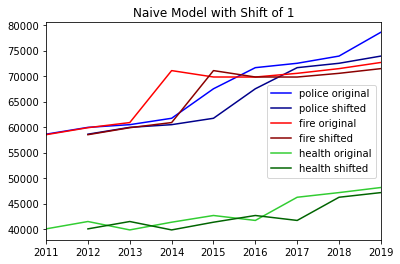

In [82]:
fig, ax = plt.subplots()

train_police[0:].plot(ax=ax, label='police original', color='blue')
train_police_pred_naive[0:].plot(ax=ax, label='police shifted', color='darkblue')
train_fire[0:].plot(ax=ax, label='fire original', color='red')
train_fire_pred_naive[0:].plot(ax=ax, label='fire shifted', color='darkred')
train_health[0:].plot(ax=ax, label='health original', color='limegreen')
train_health_pred_naive[0:].plot(ax=ax, label='health shifted', color='darkgreen')

ax.set_title('Naive Model with Shift of 1')
ax.legend()
plt.savefig('./images/Baseline_Naive_Model_with_Shift_of_1.png',bbox_inches='tight');

**For a baseline to compare our later models, lets calculate our RMSE for the naive model.**

In [87]:
RMSE_train_police = np.sqrt(mean_squared_error(train_police[1:], train_police_pred_naive.dropna()))
RMSE_train_fire = np.sqrt(mean_squared_error(train_fire[1:], train_fire_pred_naive.dropna()))
RMSE_train_health = np.sqrt(mean_squared_error(train_health[1:], train_health_pred_naive.dropna()))

print(f'Train Data Root Mean Squared Errors:')
print(f'Police: ${RMSE_train_police:,.0f}')
print(f'Fire: ${RMSE_train_fire:,.0f}')
print(f'Health: ${RMSE_train_health:,.0f}')


Train Data Root Mean Squared Errors:
Police: $3,140
Fire: $3,729
Health: $2,009


In [84]:
test_police_pred_naive = test_police.shift(1)
test_fire_pred_naive = test_fire.shift(1)
test_health_pred_naive = test_health.shift(1)

print(f'Test vs Predicted Salary:')
print(f'Police: {test_police.index[0].strftime("%Y")} Test ${test_police[0]:,.0f} Predicted ${test_police_pred_naive[0]:,.0f}')
print(f'Police: {test_police.index[1].strftime("%Y")} Test ${test_police[1]:,.0f} Predicted ${test_police_pred_naive[1]:,.0f}\n')
print(f'Fire:   {test_fire.index[0].strftime("%Y")} Test ${test_fire[0]:,.0f} Predicted ${test_fire_pred_naive[0]:,.0f}')
print(f'Fire:   {test_fire.index[1].strftime("%Y")} Test ${test_fire[1]:,.0f} Predicted ${test_fire_pred_naive[1]:,.0f}\n')
print(f'Health: {test_health.index[0].strftime("%Y")} Test ${test_health[0]:,.0f} Predicted ${test_health_pred_naive[0]:,.0f}')
print(f'Health: {test_health.index[1].strftime("%Y")} Test ${test_health[1]:,.0f} Predicted ${test_health_pred_naive[1]:,.0f}')


Test vs Predicted Salary:
Police: 2020 Test $78,460 Predicted $nan
Police: 2021 Test $78,576 Predicted $78,460

Fire:   2020 Test $72,915 Predicted $nan
Fire:   2021 Test $74,152 Predicted $72,915

Health: 2020 Test $49,614 Predicted $nan
Health: 2021 Test $46,325 Predicted $49,614


In [85]:
RMSE_test_police = np.sqrt(mean_squared_error(test_police[1:], test_police_pred_naive.dropna()))
RMSE_test_fire = np.sqrt(mean_squared_error(test_fire[1:], test_fire_pred_naive.dropna()))
RMSE_test_health = np.sqrt(mean_squared_error(test_health[1:], test_health_pred_naive.dropna()))

print(f'Root Mean Squared Errors:')
print(f'Police: ${RMSE_test_police:,.0f}')
print(f'Fire: ${RMSE_test_fire:,.0f}')
print(f'Health: ${RMSE_test_health:,.0f}')


Root Mean Squared Errors:
Police: $115
Fire: $1,237
Health: $3,290


**The naive model is generating these above RSME values for the training data.  
Let's see if we can use ARIMA to beat these errors.**

### ARIMA Model

**We have chosen the AutoRegressive Integrated Moving Average (ARIMA) model as the modeling technique to try and beat the Naive Model predictions and errors.  
-Differencing may be a method to tackle stationarity.  
-Also, if there is autocorrelation, we can try to determine the number of lags by experimenting with different lags or using the PACF/ACF functions to determine this.**  

### PACF (Differenced data) & ACF
**Partial Autocorrelation Function (PACF) and Autocorrelation Function (ACF) are useful tools to determine the number of lags or lagged errors to apply in the ARIMA model. PACF is useful for determining the number of lags for AR and ACF is useful for determining the number of lagged errors for MA.**  



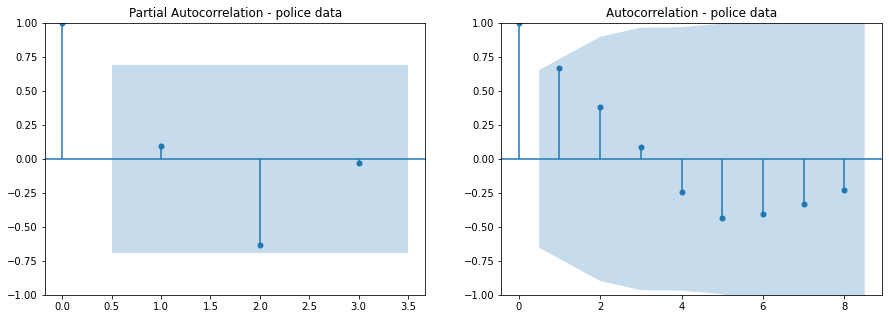

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_pacf(train_police.diff().dropna(), title='Partial Autocorrelation - police data', method='ywm', lags=3, ax=ax[0])
plot_acf(train_police, title='Autocorrelation - police data', ax=ax[1])
plt.savefig('./images/PACF&ACF_Police.png',bbox_inches='tight')
plt.show();

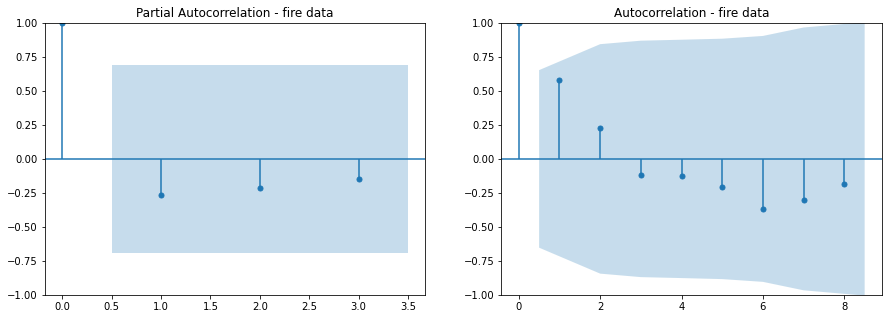

In [53]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_pacf(train_fire.diff().dropna(), title='Partial Autocorrelation - fire data', method='ywm', lags=3, ax=ax[0])
plot_acf(train_fire, title='Autocorrelation - fire data', ax=ax[1])
plt.savefig('./images/PACF&ACF_Fire.png',bbox_inches='tight')
plt.show()

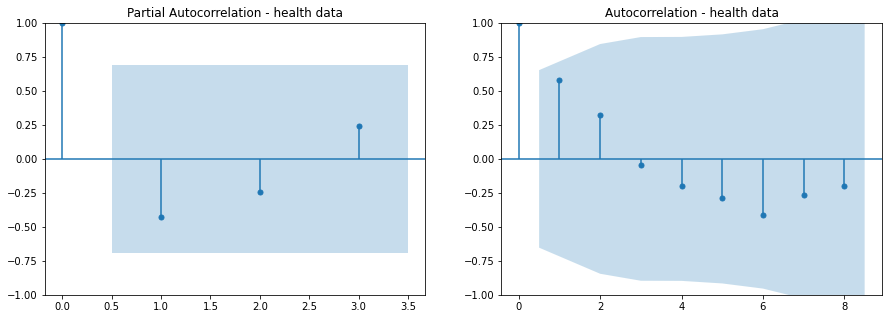

In [54]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_pacf(train_health.diff().dropna(), title='Partial Autocorrelation - health data', method='ywm', lags=3, ax=ax[0])
plot_acf(train_health, title='Autocorrelation - health data', ax=ax[1])
plt.savefig('./images/PACF&ACF_Health.png',bbox_inches='tight')
plt.show()

**This Baltimore City Salary time series data is appearing to be a "Random Walk" model. 
The PACF and ACF functions are not indicating even 1 lag or lagged error.  
Let's try ARIMA with differencing of 1.**

### ARIMA(0,1,0)  
**The (p,d,q) values of (0,1,0) mean that we are not specifying any lags and only taking a difference of 1.  
The model will be trained on the train data that was earlier split into train and test.  
The model will then be used to predict using the test data.**

In [55]:
train_police.index = pd.DatetimeIndex(train_police.index.values, freq=train_police.index.inferred_freq)
ar_police_1 = ARIMA(train_police, order=(0,1,0)).fit()

train_fire.index = pd.DatetimeIndex(train_fire.index.values, freq=train_fire.index.inferred_freq)
ar_fire_1 = ARIMA(train_fire, order=(0,1,0)).fit()

train_health.index = pd.DatetimeIndex(train_health.index.values, freq=train_health.index.inferred_freq)
ar_health_1 = ARIMA(train_health, order=(0,1,0)).fit()

# ar_police_1.summary()

In [88]:
train_police

2011-01-01    58597.219186
2012-01-01    59939.296748
2013-01-01    60467.387660
2014-01-01    61719.831720
2015-01-01    67507.705692
2016-01-01    71649.581921
2017-01-01    72508.720842
2018-01-01    73921.511519
2019-01-01    78597.113567
Freq: AS-JAN, Name: Police_Dept, dtype: float64

In [56]:
print(f'Akaike Information Criterion(AIC):')
print(f'Police: {ar_police_1.aic:,.0f}')
print(f'Fire: {ar_fire_1.aic:,.0f}')
print(f'Health: {ar_health_1.aic:,.0f}')


Akaike Information Criterion(AIC):
Police: 154
Fire: 156
Health: 146


**The lower the AIC score, the better.  
We will use these values to compare against subsequent models.**

In [57]:
train_police_pred_1 = ar_police_1.predict(typ='levels')
train_fire_pred_1 = ar_fire_1.predict(typ='levels')
train_health_pred_1 = ar_health_1.predict(typ='levels')

print(f'Root Mean Squared Errors:')
print(f'Police: ${np.sqrt(mean_squared_error(train_police, train_police_pred_1)):,.0f}')
print(f'Fire: ${np.sqrt(mean_squared_error(train_fire, train_fire_pred_1)):,.0f}')
print(f'Health: ${np.sqrt(mean_squared_error(train_health, train_health_pred_1)):,.0f}')


Root Mean Squared Errors:
Police: $19,756
Fire: $19,815
Health: $13,475


**Use model to predict against test data.**

In [74]:
test_police_pred_1 = ar_police_1.predict(start=test_police.index[0], end=test_police.index[-1],typ='levels')
test_fire_pred_1 = ar_fire_1.predict(start=test_fire.index[0], end=test_fire.index[-1],typ='levels')
test_health_pred_1 = ar_health_1.predict(start=test_health.index[0], end=test_health.index[-1],typ='levels')

print(f'Test vs Predicted Salary:')
print(f'Police: {test_police.index[0].strftime("%Y")} Test ${test_police[0]:,.0f} Predicted ${test_police_pred_1[0]:,.0f}')
print(f'Police: {test_police.index[1].strftime("%Y")} Test ${test_police[1]:,.0f} Predicted ${test_police_pred_1[1]:,.0f}\n')
print(f'Fire:   {test_fire.index[0].strftime("%Y")} Test ${test_fire[0]:,.0f} Predicted ${test_fire_pred_1[0]:,.0f}')
print(f'Fire:   {test_fire.index[1].strftime("%Y")} Test ${test_fire[1]:,.0f} Predicted ${test_fire_pred_1[1]:,.0f}\n')
print(f'Health: {test_health.index[0].strftime("%Y")} Test ${test_health[0]:,.0f} Predicted ${test_health_pred_1[0]:,.0f}')
print(f'Health: {test_health.index[1].strftime("%Y")} Test ${test_health[1]:,.0f} Predicted ${test_health_pred_1[1]:,.0f}')


Test vs Predicted Salary:
Police: 2020 Test $78,460 Predicted $78,597
Police: 2021 Test $78,576 Predicted $78,597

Fire:   2020 Test $72,915 Predicted $72,670
Fire:   2021 Test $74,152 Predicted $72,670

Health: 2020 Test $49,614 Predicted $48,138
Health: 2021 Test $46,325 Predicted $48,138


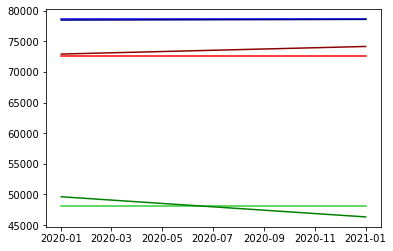

In [59]:
fig, ax = plt.subplots()
ax.plot(test_police_pred_1, label='predicted police', color='blue')
ax.plot(test_police, label='test police', color='darkblue')
ax.plot(test_fire_pred_1, label='predicted fire', color='red')
ax.plot(test_fire, label='test fire', color='darkred')
ax.plot(test_health_pred_1, label='predicted health', color='limegreen')
ax.plot(test_health, label='test health', color='green');

**Because of the limited original data set of 11 years, 9 years were dedicated to training the model and only 2 years were left for test.  
The above line chart consists of 2 data points connected to form each line.  
The Baltimore data set depicts a "Random Walk" scenario. The salary predictions are essentially based on the previous value in time and, hence the small variance between the test and predicted data.**

### ARIMA(1,1,0)

In [60]:
ar_police_2 = ARIMA(train_police, order=(1,1,0)).fit()
ar_fire_2 = ARIMA(train_fire, order=(1,1,0)).fit()
ar_health_2 = ARIMA(train_health, order=(1,1,0)).fit()

# ar_police_2.summary()

In [61]:
print(f'Akaike Information Criterion(AIC):')
print(f'Police: {ar_police_2.aic:,.0f}')
print(f'Fire: {ar_fire_2.aic:,.0f}')
print(f'Health: {ar_health_2.aic:,.0f}')


Akaike Information Criterion(AIC):
Police: 156
Fire: 158
Health: 148


**The lower the AIC score, the better.  
However, these scores are 2 pts higher than the (0,1,0) model.**

In [62]:
train_police_pred_2 = ar_police_2.predict(typ='levels')
train_fire_pred_2 = ar_fire_2.predict(typ='levels')
train_health_pred_2 = ar_health_2.predict(typ='levels')

print(f'Root Mean Squared Errors:')
print(f'Police: ${np.sqrt(mean_squared_error(train_police, train_police_pred_2)):,.0f}')
print(f'Fire: ${np.sqrt(mean_squared_error(train_fire, train_fire_pred_2)):,.0f}')
print(f'Health: ${np.sqrt(mean_squared_error(train_health, train_health_pred_2)):,.0f}')


Root Mean Squared Errors:
Police: $19,742
Fire: $19,809
Health: $13,468


**Use model to predict against test data.**

In [63]:
test_police_pred_2 = ar_police_2.predict(start=test_police.index[0], end=test_police.index[-1],typ='levels')
test_fire_pred_2 = ar_fire_2.predict(start=test_fire.index[0], end=test_fire.index[-1],typ='levels')
test_health_pred_2 = ar_health_2.predict(start=test_health.index[0], end=test_health.index[-1],typ='levels')

print(f'Root Mean Squared Errors:')
print(f'Police: {test_police.index[0].strftime("%Y")} Test ${test_police[0]:,.0f} Predicted ${test_police_pred_2[0]:,.0f}')
print(f'Police: {test_police.index[1].strftime("%Y")} Test ${test_police[1]:,.0f} Predicted ${test_police_pred_2[1]:,.0f}\n')
print(f'Fire:   {test_fire.index[0].strftime("%Y")} Test ${test_fire[0]:,.0f} Predicted ${test_fire_pred_2[0]:,.0f}')
print(f'Fire:   {test_fire.index[1].strftime("%Y")} Test ${test_fire[1]:,.0f} Predicted ${test_fire_pred_2[1]:,.0f}\n')
print(f'Health: {test_health.index[0].strftime("%Y")} Test ${test_health[0]:,.0f} Predicted ${test_health_pred_2[0]:,.0f}')
print(f'Health: {test_health.index[1].strftime("%Y")} Test ${test_health[1]:,.0f} Predicted ${test_health_pred_2[1]:,.0f}')


Root Mean Squared Errors:
Police: 2020 Test $78,460 Predicted $78,798
Police: 2021 Test $78,576 Predicted $78,806

Fire:   2020 Test $72,915 Predicted $72,700
Fire:   2021 Test $74,152 Predicted $72,700

Health: 2020 Test $49,614 Predicted $48,178
Health: 2021 Test $46,325 Predicted $48,180


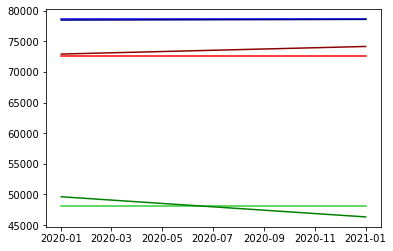

In [64]:
fig, ax = plt.subplots()
ax.plot(test_police_pred_1, label='predicted police', color='blue')
ax.plot(test_police, label='test police', color='darkblue')
ax.plot(test_fire_pred_1, label='predicted fire', color='red')
ax.plot(test_fire, label='test fire', color='darkred')
ax.plot(test_health_pred_1, label='predicted health', color='limegreen')
ax.plot(test_health, label='test health', color='green');

**The ARIMA(1,1,0) model is worse than the ARIMA(0,1,0).**

## It is clear from this analysis that the Baltimore data is essentially a Random Walk model and cannot be used in its current form to predict salaries into subsequent years.

### Code below this point was ultimately not needed for this analysis.

### Plots of Original Data and Log and Sqrt Transformed Data

In [65]:
np.log(train_police)

2011-01-01    10.978443
2012-01-01    11.001088
2013-01-01    11.009859
2014-01-01    11.030361
2015-01-01    11.119997
2016-01-01    11.179543
2017-01-01    11.191462
2018-01-01    11.210759
2019-01-01    11.272090
Freq: AS-JAN, Name: Police_Dept, dtype: float64

C:\Users\NM\AppData\Local\Temp\ipykernel_21352\2813237518.py:12: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Original Data')


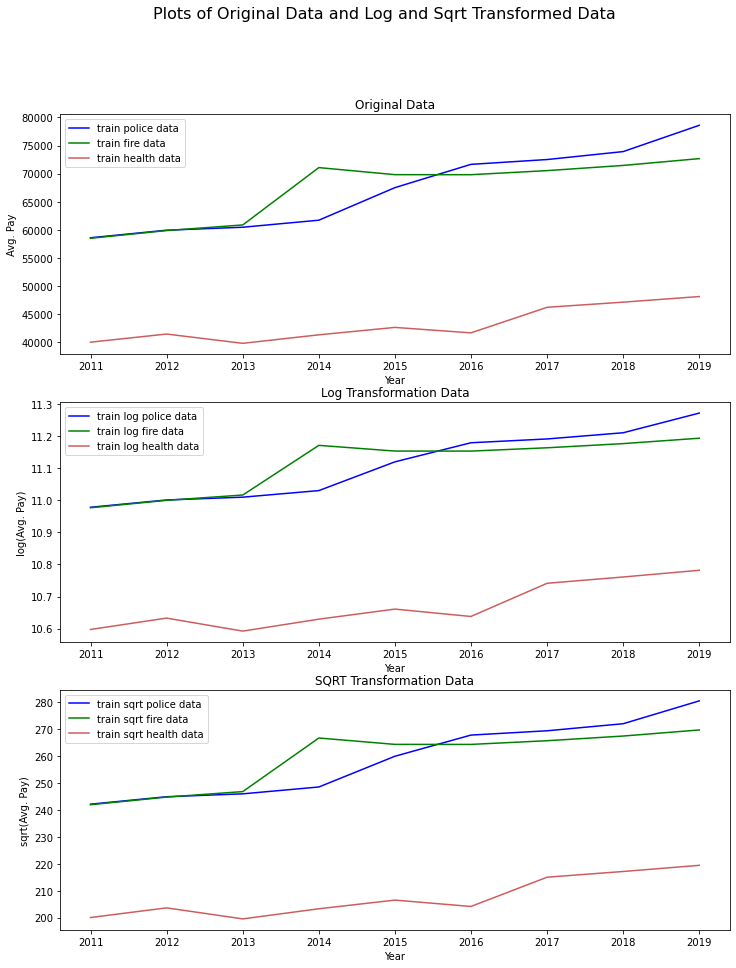

In [66]:
fig = plt.figure(figsize=(12, 15))
fig.suptitle("Plots of Original Data and Log and Sqrt Transformed Data", fontsize=16)
    
# No transformation
ax = plt.subplot(3, 1, 1)
ax.set_title("Original Data")
plt.xlabel("Year", fontsize=10)
plt.ylabel("Avg. Pay", fontsize=10)
plt.plot(train_police, color="blue", label='train police data')
plt.plot(train_fire, color="green", label='train fire data')
plt.plot(train_health, color="indianred", label='train health data')
fig.canvas.set_window_title('Original Data')
plt.legend()

# Log transformation (linear and heteroscedastic)
ax = plt.subplot(3, 1, 2)
ax.set_title("Log Transformation Data")
plt.xlabel("Year", fontsize=10)
plt.ylabel("log(Avg. Pay)", fontsize=10)
plt.plot(np.log(train_police), color="blue", label='train log police data')
plt.plot(np.log(train_fire), color="green", label='train log fire data')
plt.plot(np.log(train_health), color="indianred", label='train log health data')
plt.legend()

# Square root transformation 
ax = plt.subplot(3, 1, 3)
ax.set_title("SQRT Transformation Data")
plt.xlabel("Year", fontsize=10)
plt.ylabel("sqrt(Avg. Pay)", fontsize=10)
plt.plot(np.sqrt(train_police), color="blue", label='train sqrt police data')
plt.plot(np.sqrt(train_fire), color="green", label='train sqrt fire data')
plt.plot(np.sqrt(train_health), color="indianred", label='train sqrt health data')
plt.legend()

plt.show()

### Plots of Rolling Mean
**Ultimately, these were not needed!**

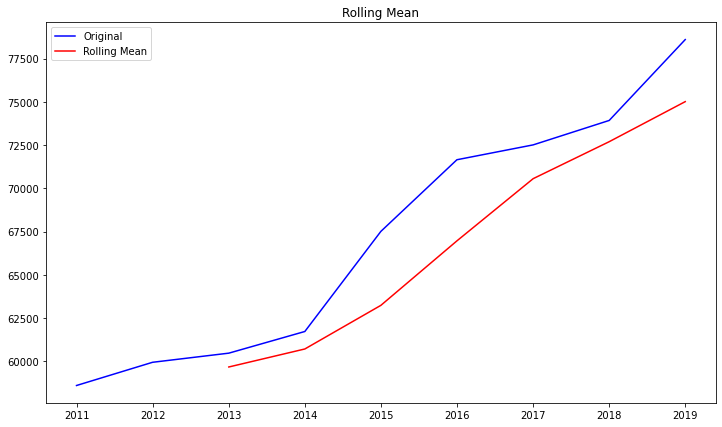

In [67]:
rolmean = train_police.rolling(window=3, center=False).mean()
rolstd = train_police.rolling(window=3, center=False).std()

fig = plt.figure(figsize=(12, 7))
orig = plt.plot(train_police, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
# std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

In [68]:
# Subtract the moving average from the original data and check head for Nans
data_sqrt_transform = pd.Series(np.sqrt(train_police))
data_log_transform = pd.Series(np.log(train_police))
data_sqrt_minus_rolmean = data_sqrt_transform - rolmean
data_log_minus_rolmean = data_log_transform - rolmean
print(data_sqrt_transform, data_sqrt_minus_rolmean)       ############## Investigate/understand the numbers


2011-01-01    242.068625
2012-01-01    244.825033
2013-01-01    245.901175
2014-01-01    248.434764
2015-01-01    259.822450
2016-01-01    267.674395
2017-01-01    269.274434
2018-01-01    271.885107
2019-01-01    280.351768
Freq: AS-JAN, Name: Police_Dept, dtype: float64 2011-01-01             NaN
2012-01-01             NaN
2013-01-01   -59422.066690
2014-01-01   -60460.403946
2015-01-01   -62971.819241
2016-01-01   -66691.365382
2017-01-01   -70286.061718
2018-01-01   -72421.386320
2019-01-01   -74728.763542
Freq: AS-JAN, Name: Police_Dept, dtype: float64


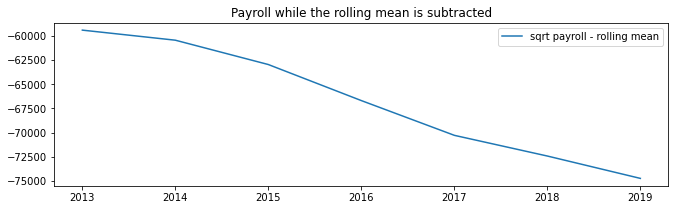

In [69]:
fig = plt.figure(figsize=(11, 3))
plt.plot(data_sqrt_minus_rolmean, label='sqrt payroll - rolling mean')
# plt.plot(data_log_minus_rolmean, label='log payroll - rolling mean')
plt.legend(loc='best')
plt.title('Payroll while the rolling mean is subtracted')
plt.show(block=False)


### Plots of Differenced Data
**Similar to ARIMA(0,1,0)**

In [70]:
diff_train_police = train_police.diff().dropna()
diff_train_fire = train_fire.diff().dropna()
diff_train_health = train_health.diff(periods=3).dropna()

In [71]:
print("Diff Police Series Stats:", '\n', Dickey_Fuller_Test(diff_train_police), '\n')
print("Diff Fire Series Stats:", '\n', Dickey_Fuller_Test(diff_train_fire), '\n')
print("Diff Health Series Stats:", '\n', Dickey_Fuller_Test(diff_train_health), '\n')

Diff Police Series Stats: 
 Test Statistic                -21.010956
p-value                         0.000000
#Lags Used                      2.000000
Number of Observations Used     5.000000
Critical Value (1%)            -6.045114
Critical Value (5%)            -3.929280
Critical Value (10%)           -2.986810
dtype: float64 

Diff Fire Series Stats: 
 Test Statistic                -1.457692e+01
p-value                        4.533281e-27
#Lags Used                     2.000000e+00
Number of Observations Used    5.000000e+00
Critical Value (1%)           -6.045114e+00
Critical Value (5%)           -3.929280e+00
Critical Value (10%)          -2.986810e+00
dtype: float64 

Diff Health Series Stats: 
 Test Statistic                -0.168634
p-value                        0.942159
#Lags Used                     0.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: fl

The P value (second value on all 3 sets of data) is close to 0 on the Police and Fire data meaning they are stationary. However, the Health data is clearly not stationary.


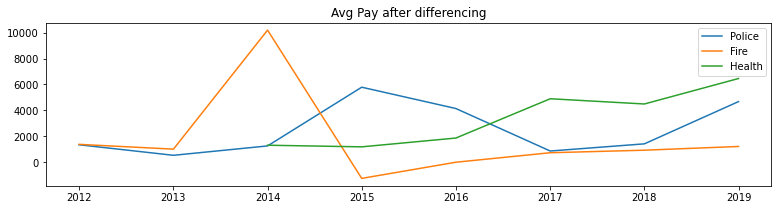

In [72]:
fig = plt.figure(figsize=(13, 3))
plt.plot(diff_train_police, label='Police')
plt.plot(diff_train_fire, label='Fire')
plt.plot(diff_train_health, label='Health')
# plt.legend(loc='best')
plt.title('Avg Pay after differencing')
plt.legend()
plt.show(block=False)


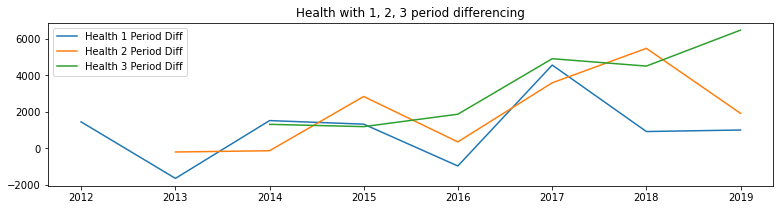

In [73]:
fig = plt.figure(figsize=(13, 3))
plt.plot(train_health.diff(periods=1).dropna(), label='Health 1 Period Diff')
plt.plot(train_health.diff(periods=2).dropna(), label='Health 2 Period Diff')
plt.plot(train_health.diff(periods=3).dropna(), label='Health 3 Period Diff')
# plt.legend(loc='best')
plt.title('Health with 1, 2, 3 period differencing')
plt.legend()
plt.show(block=False)
